In [58]:
import cv2
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm import tqdm, tqdm_notebook
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6), dpi=350)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    

def get_perspective(img, location, height=900, width=900, reverse=False):
    ordered = sorted(location, key=lambda x: x[0][0] + x[0][1])
    l_u, r_d = ordered[0][0], ordered[-1][0]
    r_u, l_d = ordered[1][0], ordered[2][0]
    if r_u[1] > l_d[1]:
        r_u, l_d = l_d, r_u
    pts1 = np.float32([l_u, l_d, r_u, r_d])
    pts2 = np.float32([[0, 0], [0, height], [width, 0], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result


def split_boxes(board): #split image into 81 squares (9x9)
    rows = np.array_split(board, 9, axis=0)
    boxes = []
    for r in rows:
        cols = np.array_split(r, 9, axis=1)
        for box in cols:
            boxes.append(box)
    return boxes

In [2]:
#Model with HoGs
class compute_hog(object): #Transform to compute HoG
    def __init__(self, cell_size, block_size, nbins):
        self.cell_size = cell_size
        self.block_size = block_size
        self.nbins = nbins

    def __call__(self, img):
        img = np.array(img)
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // self.cell_size[1] * self.cell_size[1],
                                          img.shape[0] // self.cell_size[0] * self.cell_size[0]),
                                _blockSize=(self.block_size[1] * self.cell_size[1],
                                            self.block_size[0] * self.cell_size[0]),
                                _blockStride=(self.cell_size[1], self.cell_size[0]),
                                _cellSize=(self.cell_size[1], self.cell_size[0]),
                                _nbins=self.nbins)
        return torch.tensor(hog.compute(img.astype(np.uint8)).flatten().astype(np.float32))
    
    
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_loader, test_loader, model, epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, test_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if val_acc > best_acc:
                print('BOINK')
                best_acc = val_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)

    return model, history


def predict(img, model):
    if img.sum() < 75000:
        return -1
    f = compute_hog((4,4), (3,3), 9)
    img = f(cv2.resize(img, (28, 28)))
    model.eval()
    outputs = model(torch.tensor(img)[None, ...])
    probs = nn.functional.softmax(outputs, dim=-1).detach().numpy()
    return np.argmax(probs)

In [3]:
#We will solve train_3.jpg
img = cv2.imread('train/train_3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

# Filter out all numbers and noise to isolate only boxes
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
max_area = 0
big_square = []
for c in cnts:
    area = cv2.contourArea(c)
    max_area = max(max_area, area)

for c in cnts:
    area = cv2.contourArea(c)
    if area < max_area:
        cv2.drawContours(thresh, [c], -1, (0, 0, 0), -1)
    else:
        big_square = [c]
        eps = 0.04 * cv2.arcLength(c, True)
        location = cv2.approxPolyDP(c, eps, True)
        
        
mask = np.zeros(thresh.shape)        
cv2.drawContours(mask, big_square, -1, (1,1,1), -1);      

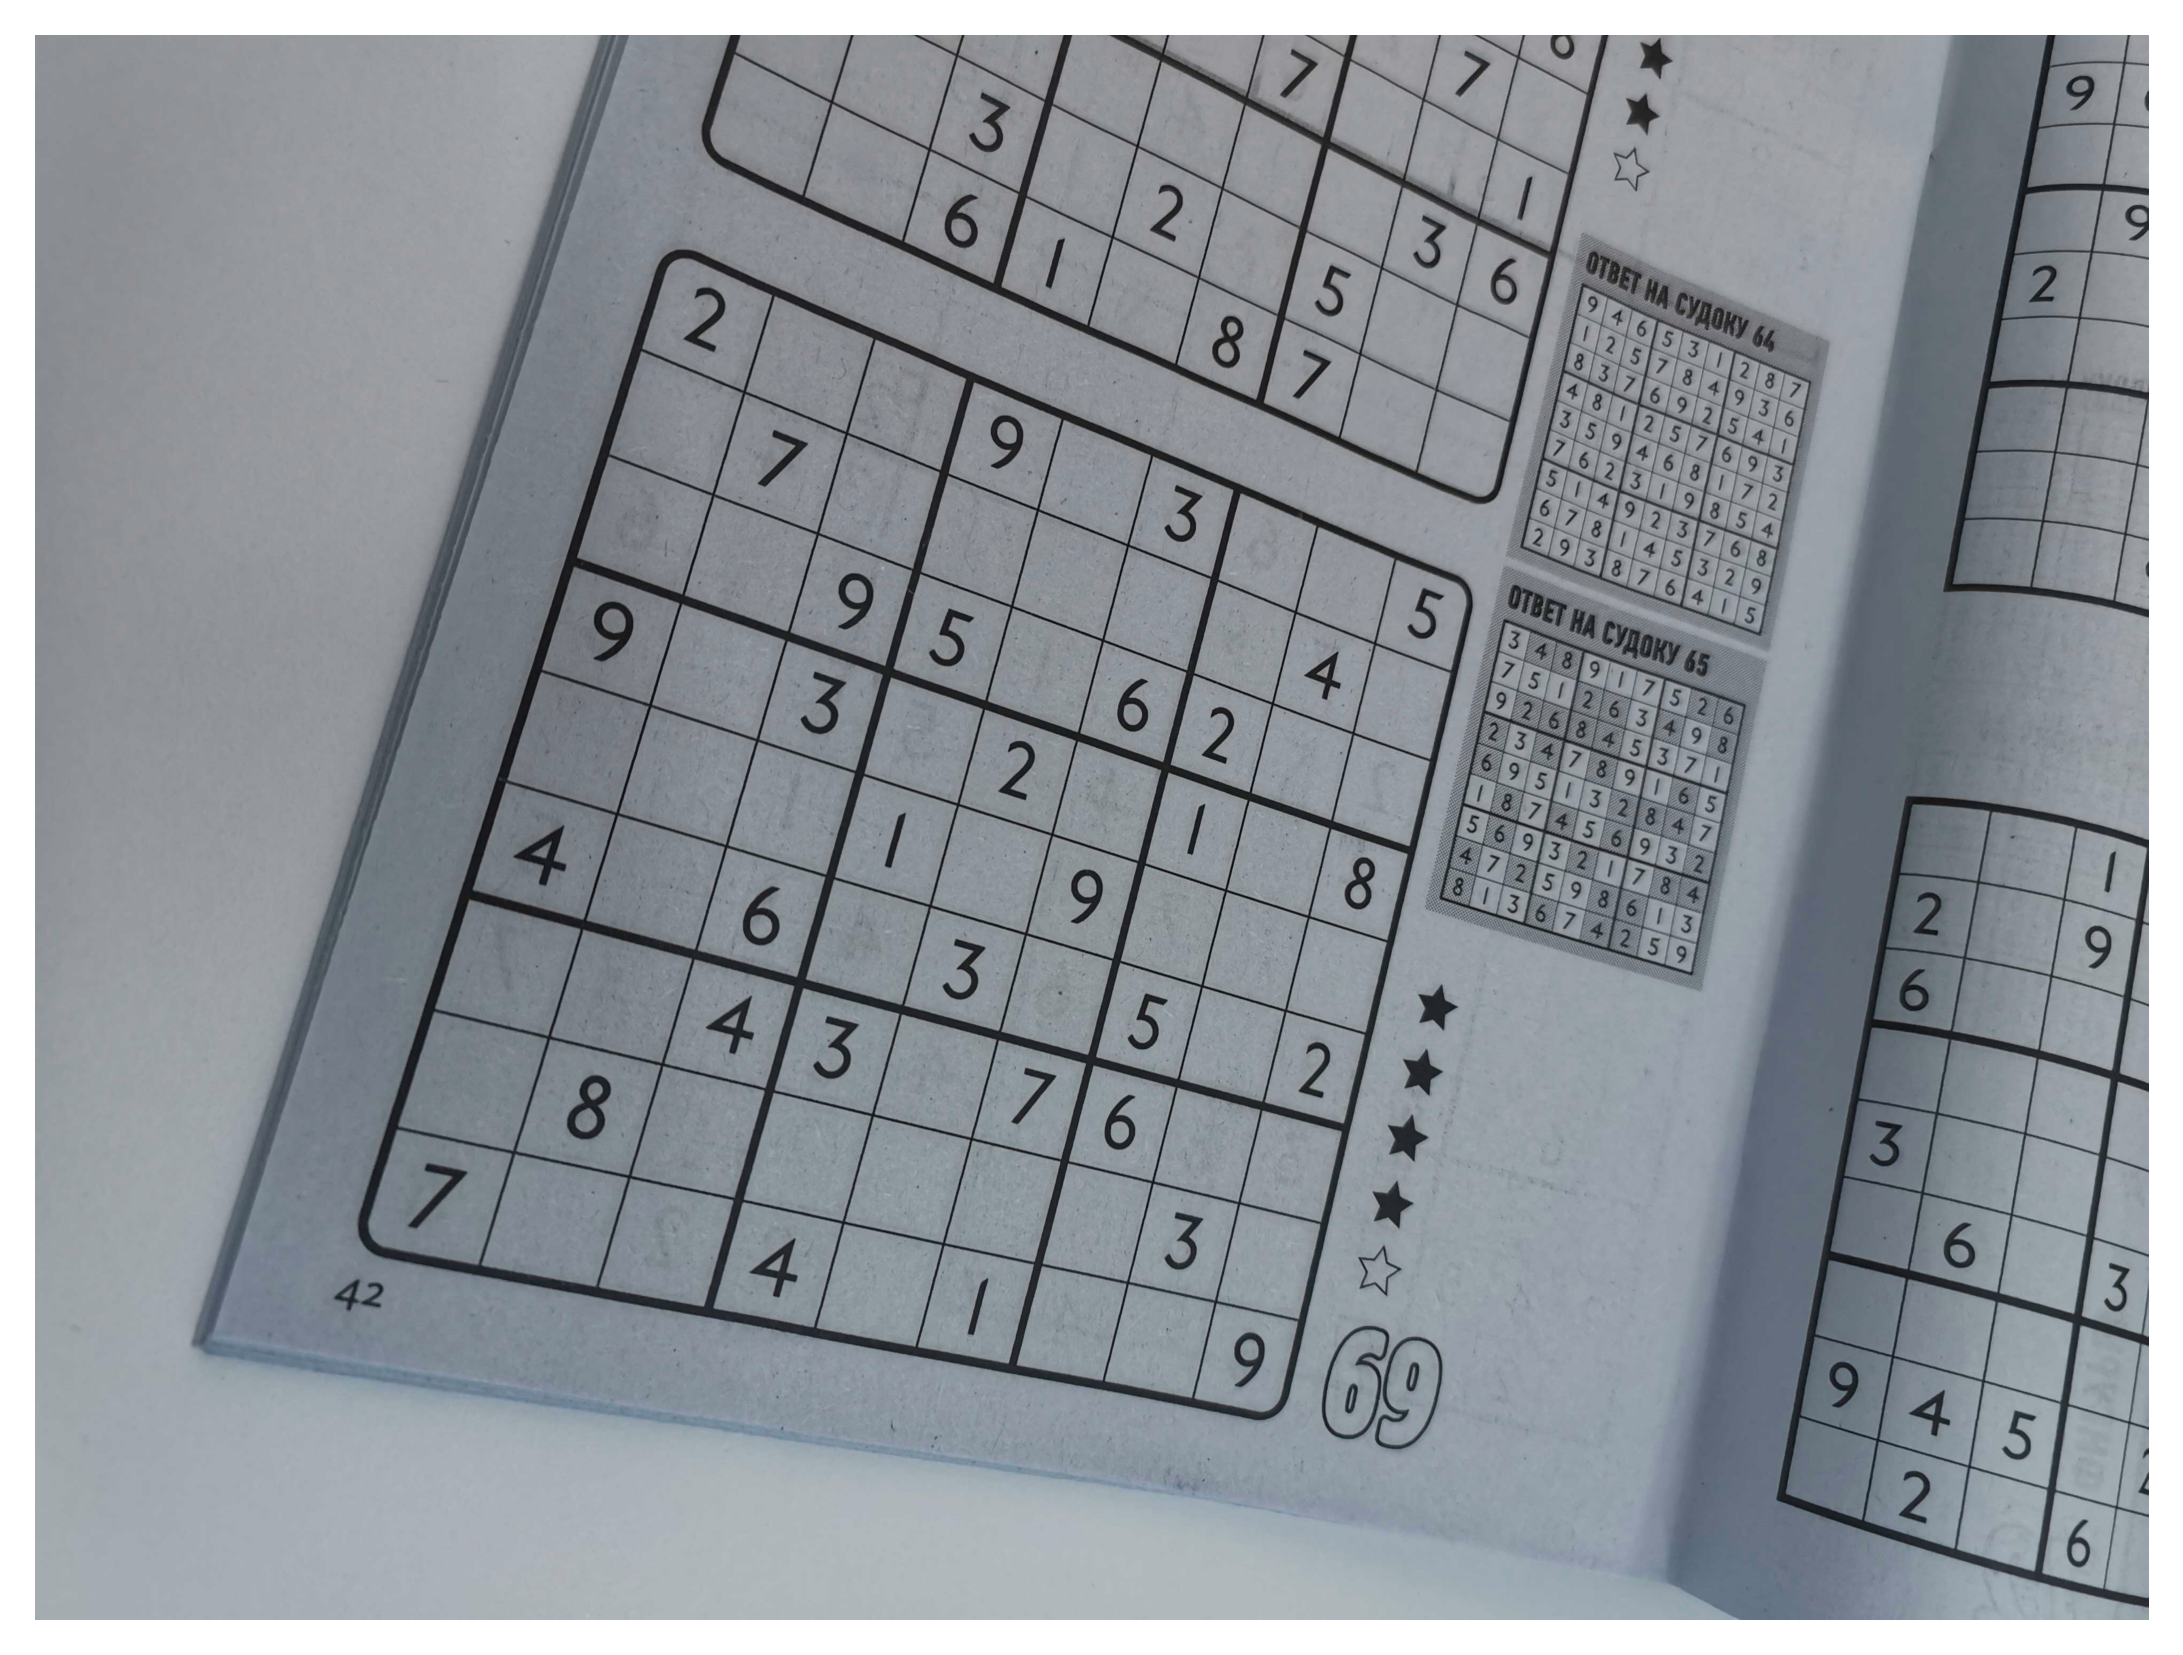

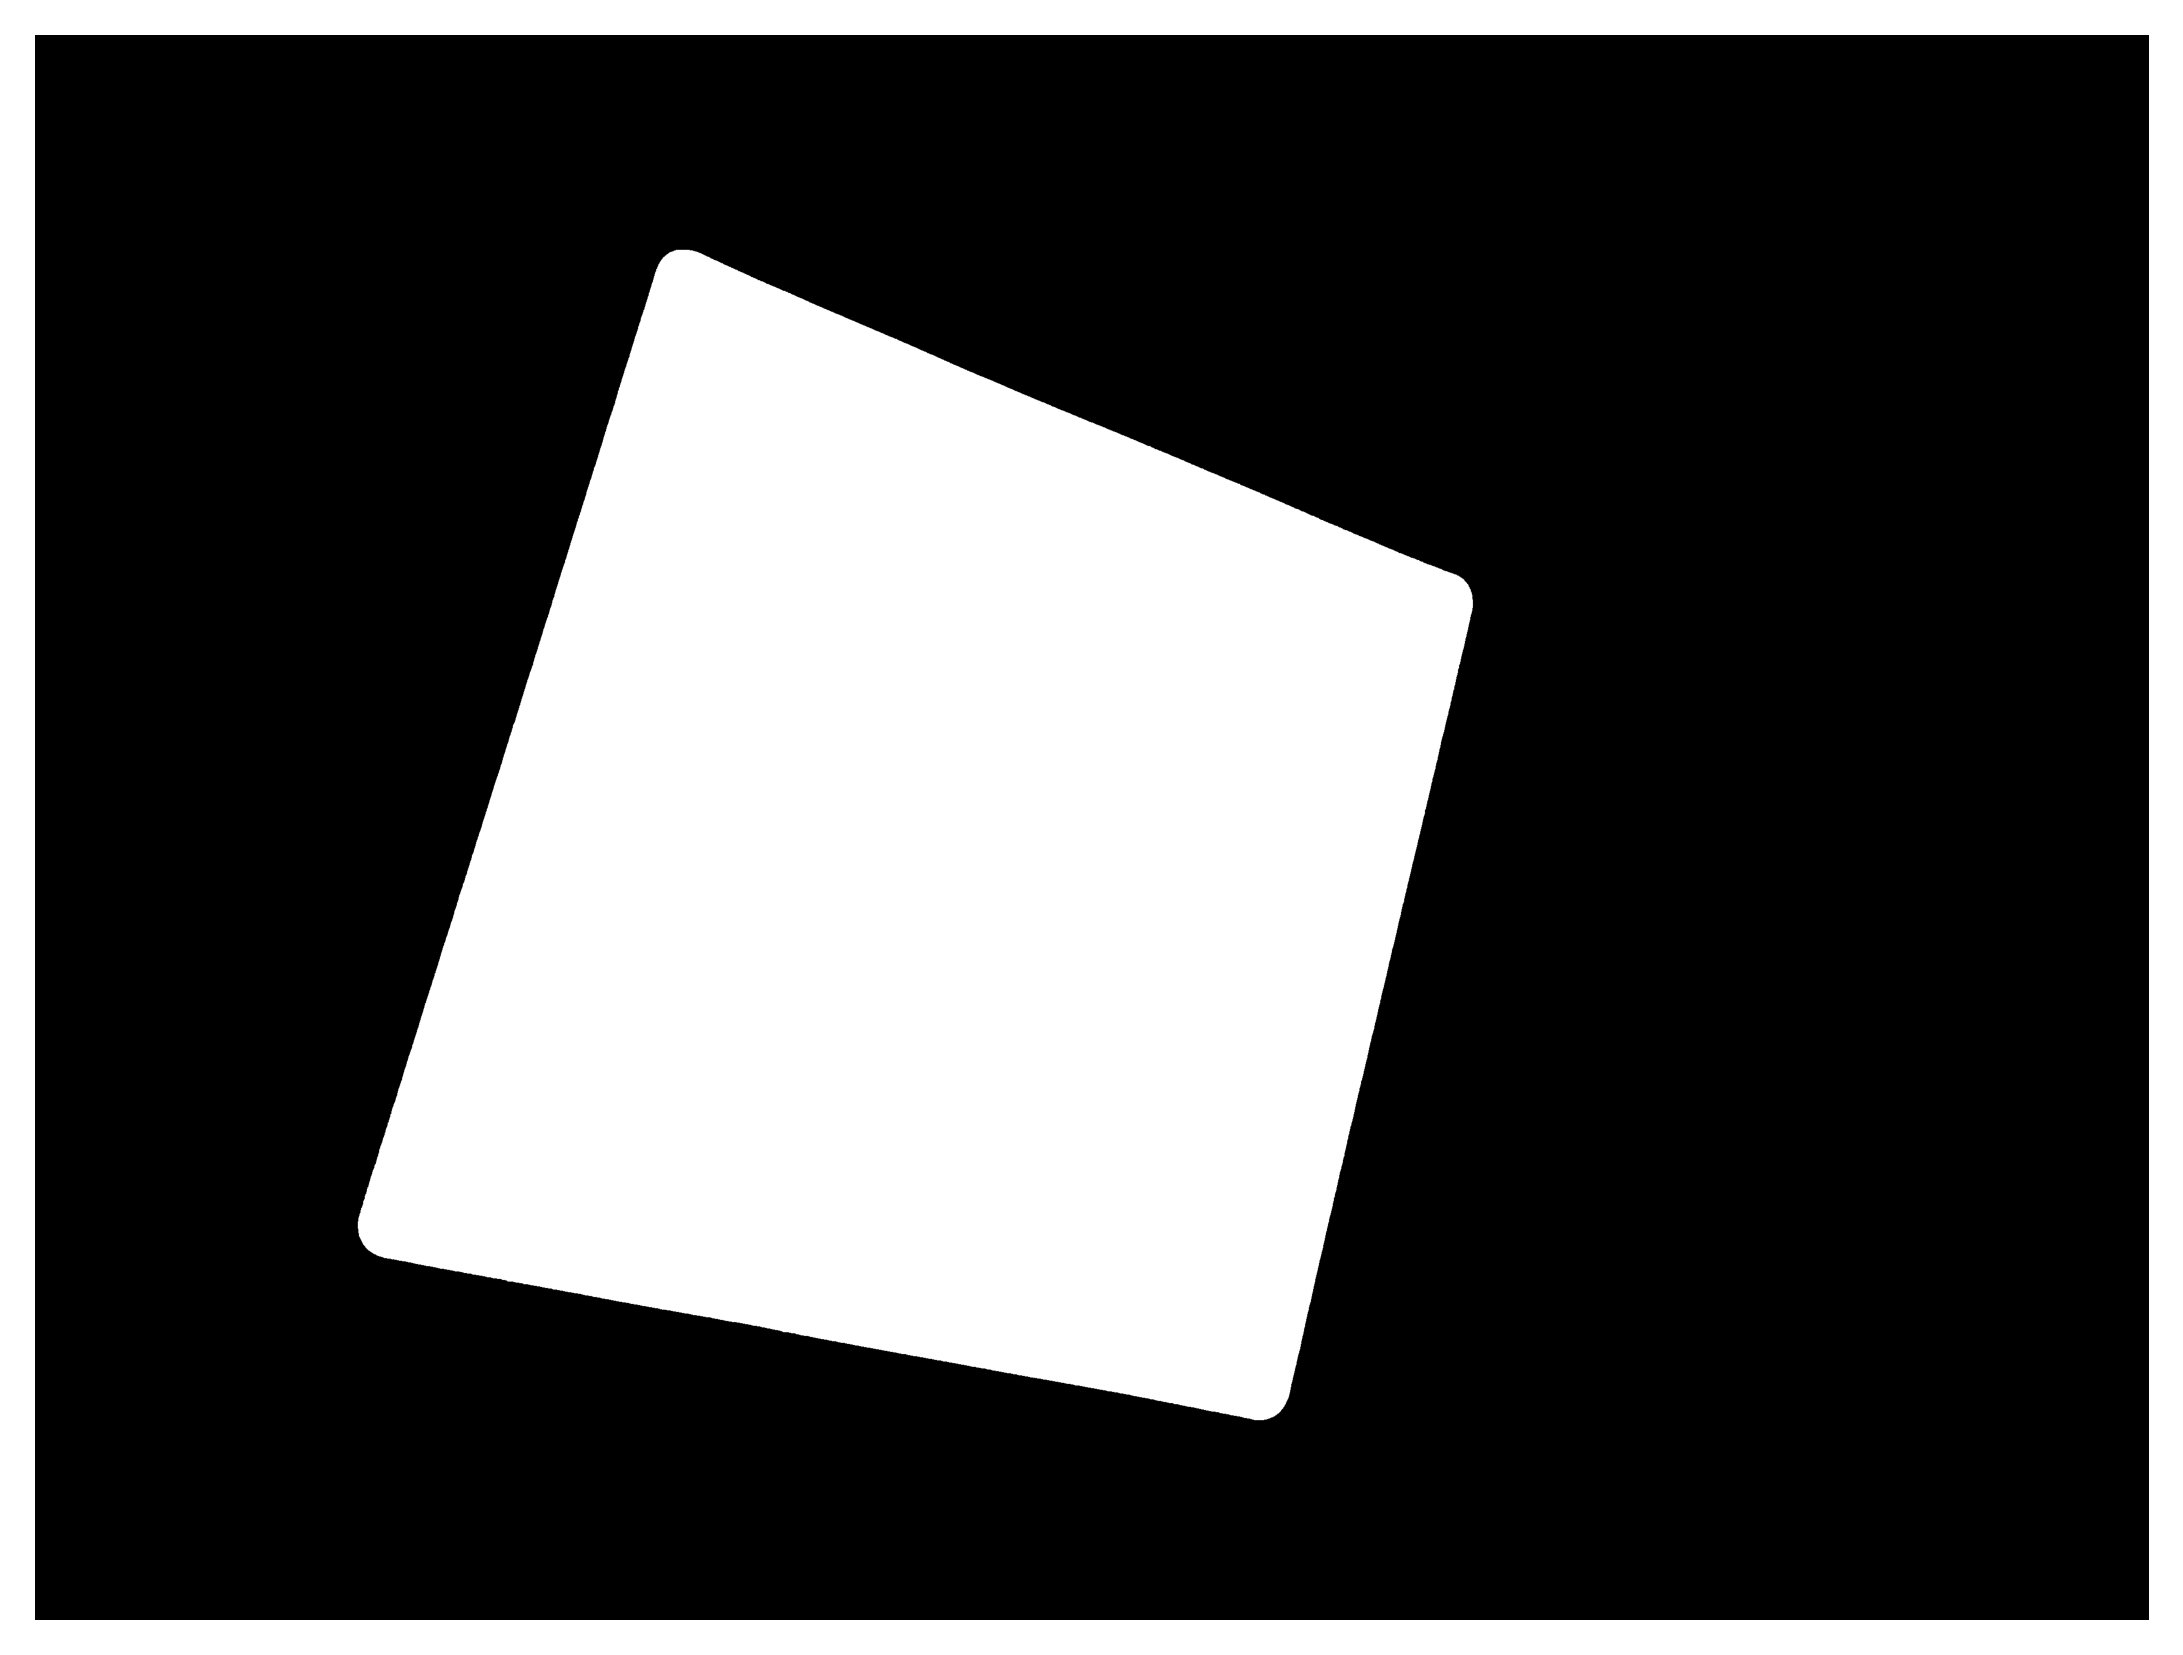

(None, None)

In [4]:
plot_img(img), plot_img(mask)

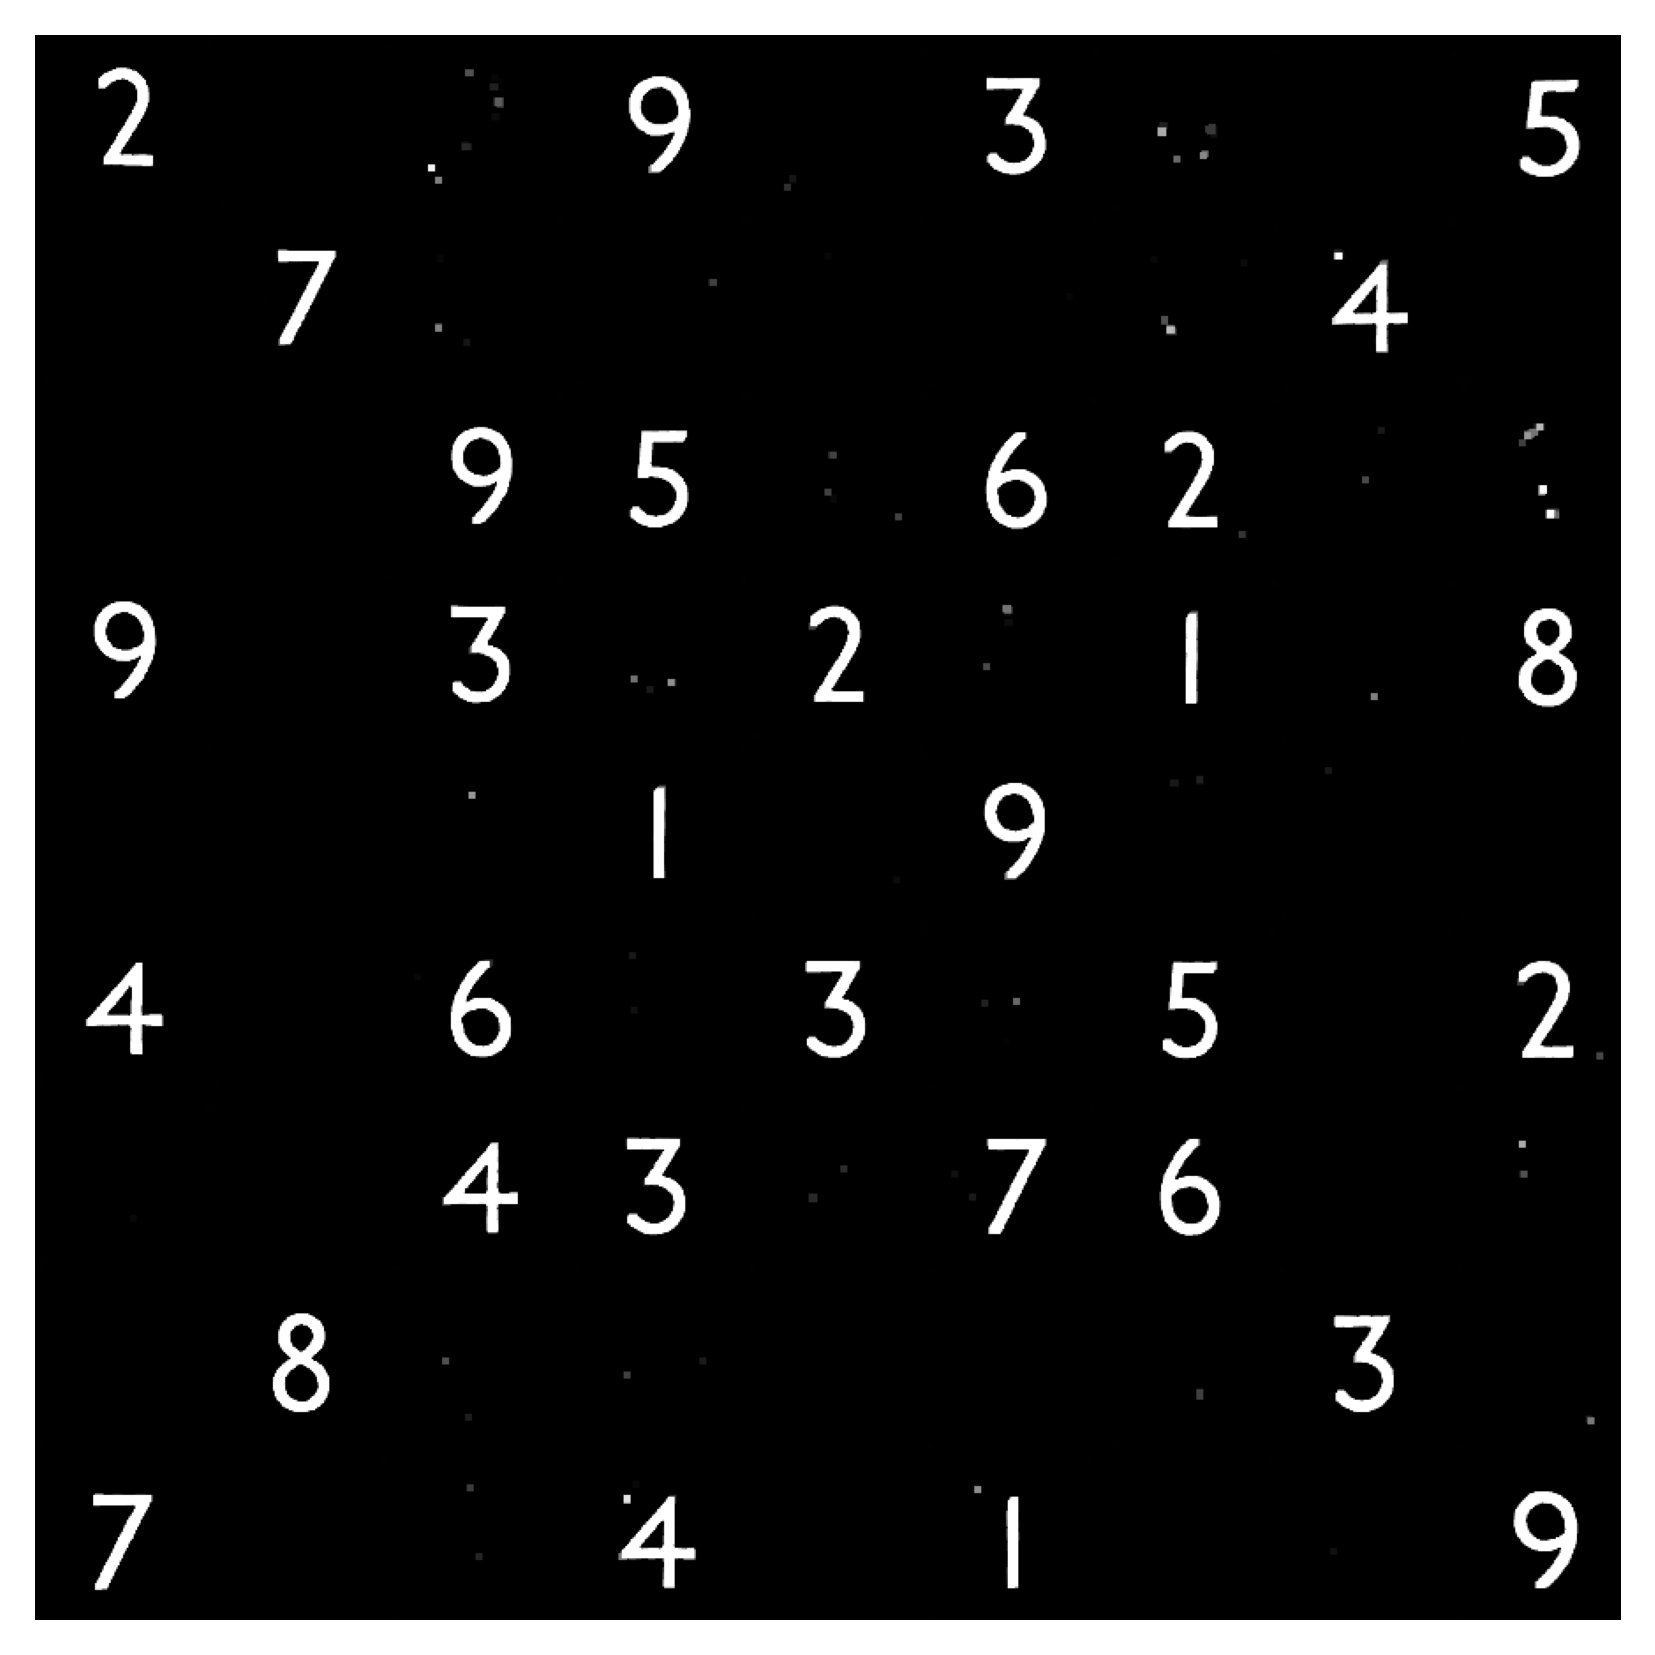

In [5]:
#denoising
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

table = get_perspective(cv2.adaptiveThreshold(gray, 255,
                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY_INV, 57,
                                              5) - thresh, location)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
table = cv2.morphologyEx(table, cv2.MORPH_OPEN, kernel, iterations=1)
table = cv2.morphologyEx(table, cv2.MORPH_OPEN, kernel_2, iterations=3)
plot_img(table)

In [6]:
#Train the model
batch_size_train = 64
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                    compute_hog((4, 4), (3, 3), 9)
                                ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                    compute_hog((4, 4), (3, 3), 9)
                                ])),
    batch_size=batch_size_test, shuffle=True)

model = nn.Sequential(
    nn.Linear(2025, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model_1, history = train(train_loader, test_loader, model=model, epochs=5)

epoch:   0%|                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

loss 0.12024843717962504


epoch:  20%|███████████████████████████▊                                                                                                               | 1/5 [00:06<00:26,  6.68s/it]


Epoch 001 train_loss: 0.1202     val_loss 0.0512 train_acc 0.9655 val_acc 0.9837
BOINK
loss 0.04542125884387642


epoch:  40%|███████████████████████████████████████████████████████▌                                                                                   | 2/5 [00:13<00:19,  6.65s/it]


Epoch 002 train_loss: 0.0454     val_loss 0.0493 train_acc 0.9856 val_acc 0.9832
loss 0.03168057645040875


epoch:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3/5 [00:19<00:13,  6.63s/it]


Epoch 003 train_loss: 0.0317     val_loss 0.0328 train_acc 0.9900 val_acc 0.9885
BOINK
loss 0.023723706928927762


epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4/5 [00:26<00:06,  6.63s/it]


Epoch 004 train_loss: 0.0237     val_loss 0.0397 train_acc 0.9925 val_acc 0.9873
loss 0.02004378414514164


epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.70s/it]


Epoch 005 train_loss: 0.0200     val_loss 0.0298 train_acc 0.9936 val_acc 0.9904
BOINK


In [7]:
boxes = split_boxes(table)

ans = []
for i in range(9):
    row = []
    for j in range(9):
        row += [predict(boxes[9 * i + j], model_1)]
    ans += [row]
ans[-1][3] = 4

In [12]:
from sudoku import solve, print_field

In [45]:
ans = np.array(ans).astype(np.float)
ans[ans == -1] = np.NaN
res = solve(ans)
solved = next(res)

In [39]:
#digits from sudoku
digits = {1:boxes[33], 2:boxes[0], 3:boxes[5], 4:boxes[16], 5:boxes[8], 6:boxes[23],
          7:boxes[10], 8:boxes[35], 9:boxes[-1]}

In [53]:
new_boxes = [digits[i] for i in solved.flatten()]
whole_pic = np.zeros(shape=(900,900))
k = 0
for i in range(100, 901, 100):
    for j in range(100, 901, 100):
        whole_pic[(i-100):i, (j-100):j] = new_boxes[k]
        k += 1

In [79]:
resized = cv2.resize(whole_pic, (3968, 2976))

(2976, 3968)

In [86]:
#perspective transform
ordered = sorted(location, key=lambda x: x[0][0] + x[0][1])
l_u, r_d = ordered[0][0], ordered[-1][0]
r_u, l_d = ordered[1][0], ordered[2][0]
if r_u[1] > l_d[1]:
    r_u, l_d = l_d, r_u
pts1 = np.float32([l_u, l_d, r_u, r_d])
pts2 = np.float32([[0, 0], [0, 2976], [3968, 0], [3968, 2976]])
matrix = cv2.getPerspectiveTransform(pts2, pts1)
result = cv2.warpPerspective(resized, matrix, (3968, 2976))

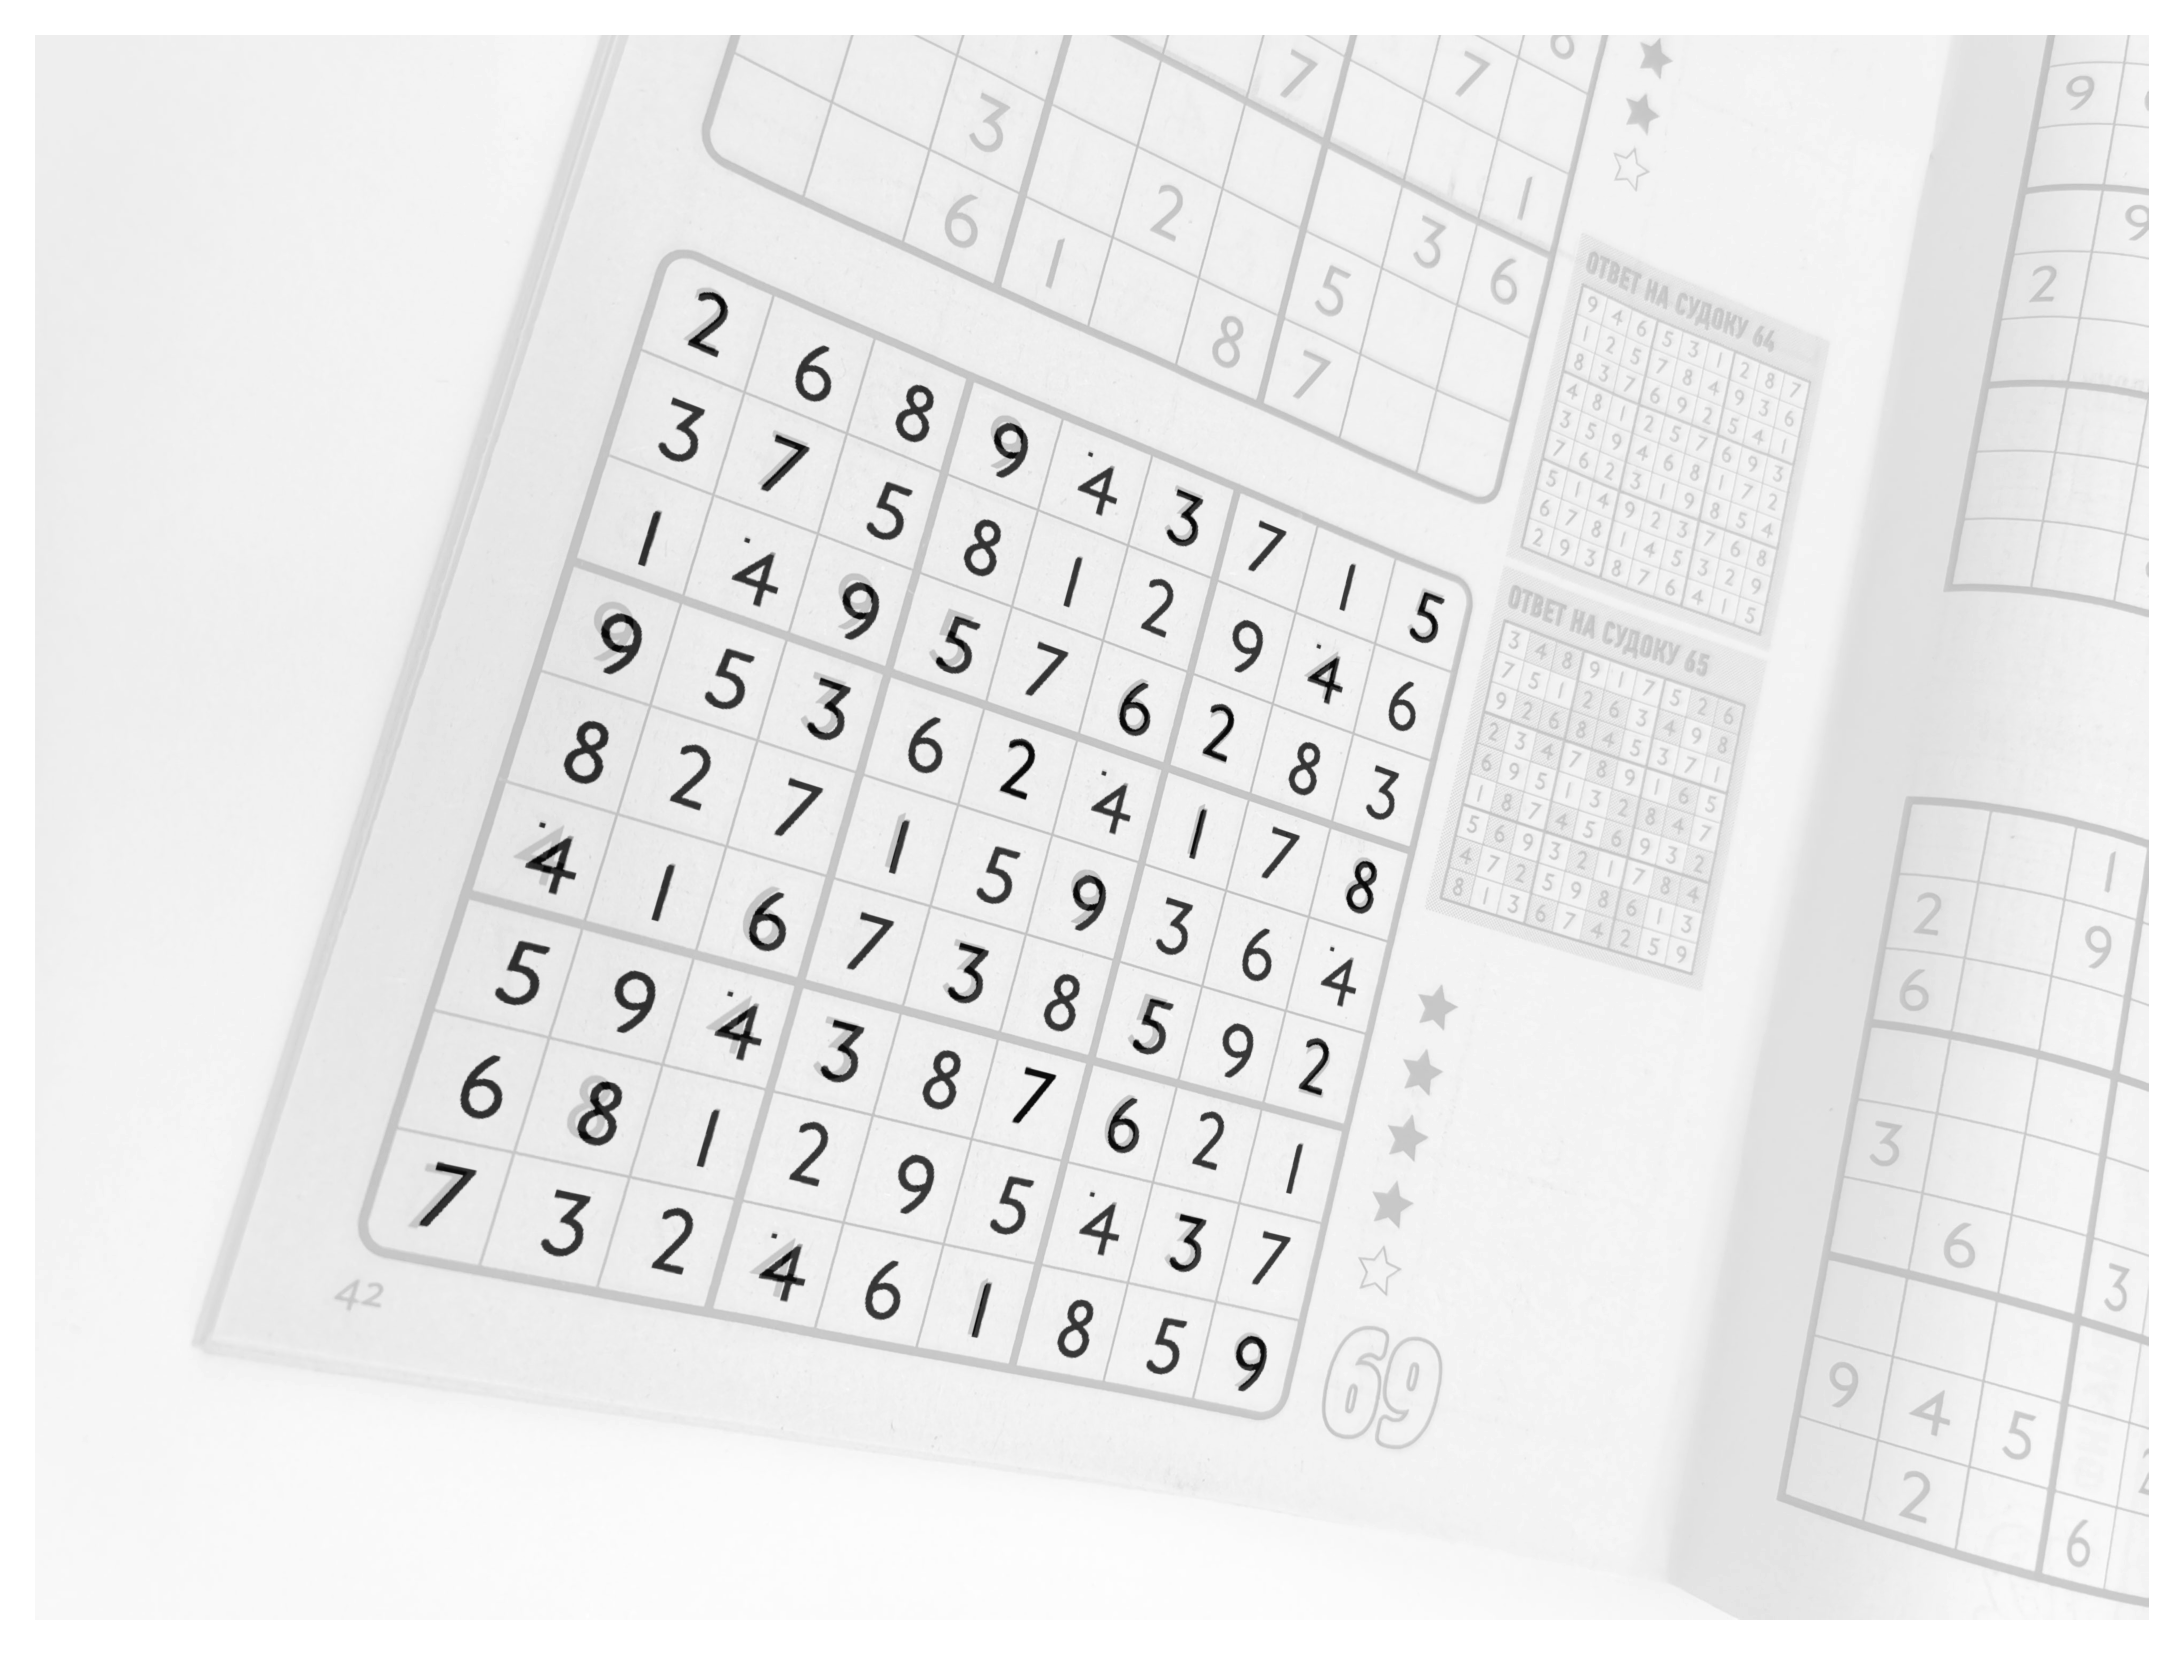

In [111]:
#final result
copy = 255 - result
plot_img((gray + 2 * copy))